# QoE Workshop Paper



In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import ipaddress
import re

from collections import defaultdict
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from bokeh.plotting import figure, show, output_notebook
from bokeh.charts import *
output_notebook()

from sqlalchemy import create_engine, text, func, or_, and_, not_
from sqlalchemy.orm import sessionmaker
from sqlalchemy.pool import NullPool

from model.Base import Base
from model.User import User
from model.Device import Device
from model.DeviceTraffic import DeviceTraffic
from model.DeviceAppTraffic import DeviceAppTraffic
from model.HttpReq import HttpReq
from model.DnsReq import DnsReq
from model.Location import Location
from model.user_devices import user_devices;

import datautils

DB='postgresql+psycopg2:///ucnstudy'

engine = create_engine(DB, echo=False, poolclass=NullPool)
Base.metadata.bind = engine
Session = sessionmaker(bind=engine)

sns.set(style="whitegrid", context="paper")
palette = sns.light_palette("grey", n_colors=8, reverse=True)
revpalette = sns.light_palette("grey", n_colors=8, reverse=False)
sns.set_palette(palette)
sns.set_color_codes()

cmap = sns.light_palette("grey", as_cmap=True)


Loading BokehJS ...

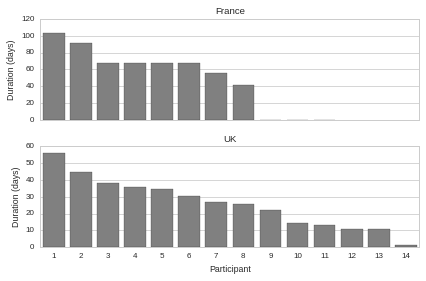

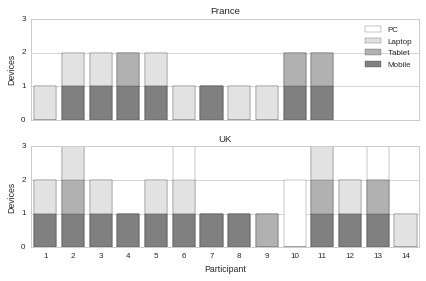

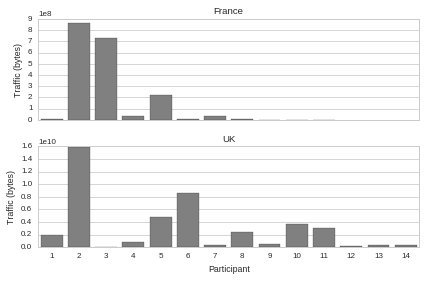

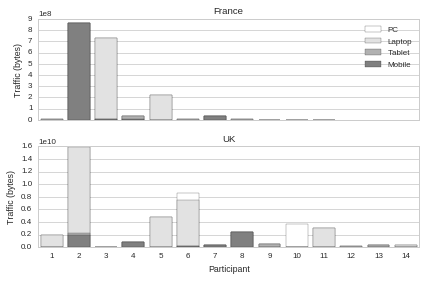

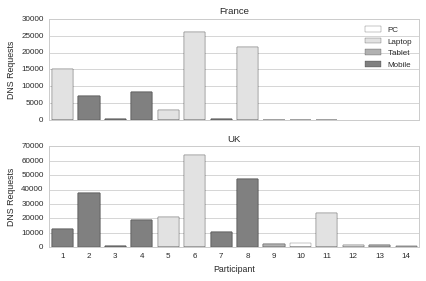

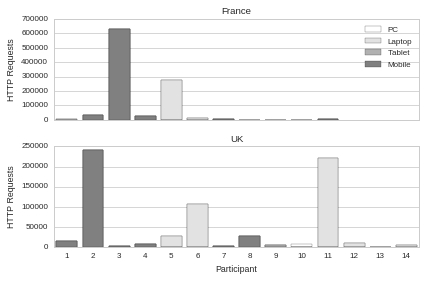

In [2]:
ses = Session()

data = defaultdict(list)
for u in ses.query(User).all():    
    devs = [d.id for d in u.devices if not d.shared]
    
    data['uid'].append(u.id)
    data['devsmobile'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'phone')]))
    data['devstablet'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'tablet')]))
    data['devspc'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'pc')]))
    data['devslaptop'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'laptop')]))
    data['devs'].append(len(devs))
    data['cc'].append(u.country)
    
    # experiment duration / user
    q = ses.query(func.min(DeviceAppTraffic.ts), 
                  func.max(DeviceAppTraffic.ts)).filter(DeviceAppTraffic.devid.in_(devs))
    (mints, maxts) = q.one()
    data['starttime'].append(mints)
    data['endtime'].append(maxts)
    if (mints!=None and maxts!=None):
        data['dur'].append((maxts-mints).total_seconds()/(24*3600.0))
    else:
        data['dur'].append(0.0)
        
    # bytes per device
    q = ses.query(DeviceAppTraffic.devid, 
                  func.sum(DeviceAppTraffic.bytes_in), 
                  func.sum(DeviceAppTraffic.bytes_out)).filter(
                    DeviceAppTraffic.devid.in_(devs)).group_by(DeviceAppTraffic.devid)
    
    bytesmobile = 0
    bytestablet = 0
    bytespc = 0
    byteslaptop = 0
    for (devid, byin, byout) in q.all():        
        bytes = 0
        if (byin!=None):
            bytes += byin
        if (byout!=None):
            bytes += byout
        d = [d for d in u.devices if d.id == devid][0]
        
        if (d.devtype == 'phone'):
            bytesmobile += bytes
        elif (d.devtype == 'tablet'):
            bytestablet += bytes
        elif (d.devtype == 'pc'):
            bytespc += bytes
        elif (d.devtype == 'laptop'):
            byteslaptop += bytes
            
    data['devsmobileb'].append(bytesmobile)
    data['devstabletb'].append(bytestablet)
    data['devspcb'].append(bytespc)
    data['devslaptopb'].append(byteslaptop)
    data['bytes'].append(byteslaptop+bytespc+bytestablet+bytesmobile)
    
    # dns reqs per device
    q = ses.query(DnsReq.devid, 
                  func.count(DnsReq.devid)).filter(
                    DnsReq.devid.in_(devs)).group_by(DnsReq.devid)
    
    bytesmobile = 0
    bytestablet = 0
    bytespc = 0
    byteslaptop = 0
    for (devid, bytes) in q.all():                
        if (d.devtype == 'phone'):
            bytesmobile += bytes
        elif (d.devtype == 'tablet'):
            bytestablet += bytes
        elif (d.devtype == 'pc'):
            bytespc += bytes
        elif (d.devtype == 'laptop'):
            byteslaptop += bytes
            
    data['devsmobiledns'].append(bytesmobile)
    data['devstabletdns'].append(bytestablet)
    data['devspcdns'].append(bytespc)
    data['devslaptopdns'].append(byteslaptop)
    data['dns'].append(byteslaptop+bytespc+bytestablet+bytesmobile)    
    
    # http reqs per device
    q = ses.query(HttpReq.devid, 
                  func.count(HttpReq.devid)).filter(
                    HttpReq.devid.in_(devs)).group_by(HttpReq.devid)
    
    bytesmobile = 0
    bytestablet = 0
    bytespc = 0
    byteslaptop = 0
    for (devid, bytes) in q.all():                
        if (d.devtype == 'phone'):
            bytesmobile += bytes
        elif (d.devtype == 'tablet'):
            bytestablet += bytes
        elif (d.devtype == 'pc'):
            bytespc += bytes
        elif (d.devtype == 'laptop'):
            byteslaptop += bytes
            
    data['devsmobilehttp'].append(bytesmobile)
    data['devstablethttp'].append(bytestablet)
    data['devspchttp'].append(bytespc)
    data['devslaptophttp'].append(byteslaptop)
    data['http'].append(byteslaptop+bytespc+bytestablet+bytesmobile)    
            
ses.close()

df = pd.DataFrame(data, index=range(0,len(data['uid']),1))    

# stacked counts
df['devstablet2'] = df['devstablet']+df['devsmobile']
df['devslaptop2'] = df['devstablet']+df['devsmobile']+df['devslaptop']
df['devspc2'] = df['devstablet']+df['devsmobile']+df['devslaptop']+df['devspc']

# stacked byte counts
df['devstabletb2'] = df['devstabletb']+df['devsmobileb']
df['devslaptopb2'] = df['devstabletb']+df['devsmobileb']+df['devslaptopb']
df['devspcb2'] = df['devstabletb']+df['devsmobileb']+df['devslaptopb']+df['devspcb']

# stacked dns counts
df['devstabletdns2'] = df['devstabletdns']+df['devsmobiledns']
df['devslaptopdns2'] = df['devstabletdns']+df['devsmobiledns']+df['devslaptopdns']
df['devspcdns2'] = df['devstabletdns']+df['devsmobiledns']+df['devslaptopdns']+df['devspcdns']

# stacked http counts
df['devstablethttp2'] = df['devstablethttp']+df['devsmobilehttp']
df['devslaptophttp2'] = df['devstablethttp']+df['devsmobilehttp']+df['devslaptophttp']
df['devspchttp2'] = df['devstablethttp']+df['devsmobilehttp']+df['devslaptophttp']+df['devspchttp']


# FRANCE
df1 = df[df['cc']=='fr'].sort_values('dur', ascending=False)
df1['x'] = list(range(1, len(df1['uid'])+1, 1))

# UK
df2 = df[df['cc']=='uk'].sort_values('dur', ascending=False)
df2['x'] = list(range(1, len(df2['uid'])+1, 1))

# participation duration per person
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

sns.barplot(data=df1, x='x', y='dur', ax=ax1, color=palette[0])
ax1.set_ylabel("Duration (days)")
ax1.set_xlabel("")
ax1.set_title("France")

sns.barplot(data=df2, x='x', y='dur', ax=ax2, color=palette[0])
ax2.set_ylabel("Duration (days)")
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/participants.eps")


# device counts per user
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
sns.barplot(data=df1, x='x', y='devspc2', ax=ax1, color='white', label='PC')
sns.barplot(data=df1, x='x', y='devslaptop2', ax=ax1, color=palette[6], label='Laptop')
sns.barplot(data=df1, x='x', y='devstablet2', ax=ax1, color=palette[3], label='Tablet')
sns.barplot(data=df1, x='x', y='devsmobile', ax=ax1, color=palette[0], label='Mobile')

ax1.set_ylabel("Devices")
ax1.set_ylim(0,3)
ax1.set_yticks([0,1,2,3])
ax1.set_xlabel("")
ax1.set_title("France")
ax1.legend(loc='best')
    
sns.barplot(data=df2, x='x', y='devspc2', ax=ax2, color='white', label='PC')
sns.barplot(data=df2, x='x', y='devslaptop2', ax=ax2, color=palette[6], label='Laptop')
sns.barplot(data=df2, x='x', y='devstablet2', ax=ax2, color=palette[3], label='Tablet')
sns.barplot(data=df2, x='x', y='devsmobile', ax=ax2, color=palette[0], label='Mobile')

ax2.set_ylabel("Devices")
ax2.set_ylim(0,3)
ax2.set_yticks([0,1,2,3])
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/devs.eps")


# participation bytes per person
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

sns.barplot(data=df1, x='x', y='bytes', ax=ax1, color=palette[0])
ax1.set_ylabel("Traffic (bytes)")
ax1.set_xlabel("")
ax1.set_title("France")

sns.barplot(data=df2, x='x', y='bytes', ax=ax2, color=palette[0])
ax2.set_ylabel("Traffic (bytes)")
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/participantbytes.eps")


# byte counts per user
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
sns.barplot(data=df1, x='x', y='devspcb2', ax=ax1, color='white', label='PC')
sns.barplot(data=df1, x='x', y='devslaptopb2', ax=ax1, color=palette[6], label='Laptop')
sns.barplot(data=df1, x='x', y='devstabletb2', ax=ax1, color=palette[3], label='Tablet')
sns.barplot(data=df1, x='x', y='devsmobileb', ax=ax1, color=palette[0], label='Mobile')

ax1.set_ylabel("Traffic (bytes)")
ax1.set_xlabel("")
ax1.set_title("France")
ax1.legend(loc='best')
    
sns.barplot(data=df2, x='x', y='devspcb2', ax=ax2, color='white', label='PC')
sns.barplot(data=df2, x='x', y='devslaptopb2', ax=ax2, color=palette[6], label='Laptop')
sns.barplot(data=df2, x='x', y='devstabletb2', ax=ax2, color=palette[3], label='Tablet')
sns.barplot(data=df2, x='x', y='devsmobileb', ax=ax2, color=palette[0], label='Mobile')

ax2.set_ylabel("Traffic (bytes)")
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/devbytes.eps")



# dns counts per user
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
sns.barplot(data=df1, x='x', y='devspcdns2', ax=ax1, color='white', label='PC')
sns.barplot(data=df1, x='x', y='devslaptopdns2', ax=ax1, color=palette[6], label='Laptop')
sns.barplot(data=df1, x='x', y='devstabletdns2', ax=ax1, color=palette[3], label='Tablet')
sns.barplot(data=df1, x='x', y='devsmobiledns', ax=ax1, color=palette[0], label='Mobile')

ax1.set_ylabel("DNS Requests")
ax1.set_xlabel("")
ax1.set_title("France")
ax1.legend(loc='best')
    
sns.barplot(data=df2, x='x', y='devspcdns2', ax=ax2, color='white', label='PC')
sns.barplot(data=df2, x='x', y='devslaptopdns2', ax=ax2, color=palette[6], label='Laptop')
sns.barplot(data=df2, x='x', y='devstabletdns2', ax=ax2, color=palette[3], label='Tablet')
sns.barplot(data=df2, x='x', y='devsmobiledns', ax=ax2, color=palette[0], label='Mobile')

ax2.set_ylabel("DNS Requests")
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/devdns.eps")


# http counts per user
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
sns.barplot(data=df1, x='x', y='devspchttp2', ax=ax1, color='white', label='PC')
sns.barplot(data=df1, x='x', y='devslaptophttp2', ax=ax1, color=palette[6], label='Laptop')
sns.barplot(data=df1, x='x', y='devstablethttp2', ax=ax1, color=palette[3], label='Tablet')
sns.barplot(data=df1, x='x', y='devsmobilehttp', ax=ax1, color=palette[0], label='Mobile')

ax1.set_ylabel("HTTP Requests")
ax1.set_xlabel("")
ax1.set_title("France")
ax1.legend(loc='best')
    
sns.barplot(data=df2, x='x', y='devspchttp2', ax=ax2, color='white', label='PC')
sns.barplot(data=df2, x='x', y='devslaptophttp2', ax=ax2, color=palette[6], label='Laptop')
sns.barplot(data=df2, x='x', y='devstablethttp2', ax=ax2, color=palette[3], label='Tablet')
sns.barplot(data=df2, x='x', y='devsmobilehttp', ax=ax2, color=palette[0], label='Mobile')

ax2.set_ylabel("HTTP Requests")
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/devhttp.eps")

In [3]:
# Selected top users
frselected = df1['uid'].head(6)
ukselected = df2['uid'].head(6)

frdevsperuser = {}
ukdevsperuser = {}
devsperuser = {}

# Selected top-devices
selecteddevs = []
for u in ses.query(User).filter(or_(User.id.in_(frselected),User.id.in_(ukselected))).all(): 
    udevs = [d.id for d in u.devices if not d.shared]
    if (u.country == 'fr'):
        frdevsperuser[u.id] = udevs
    else:
        ukdevsperuser[u.id] = udevs        
    devsperuser[u.id] = udevs        
    selecteddevs += udevs


23 [1, 2, 4, 5, 8, 7, 3, 10, 12, 11, 19, 18, 20, 23, 25, 24, 26, 27, 35, 34, 43, 47, 46]


### Take Aways

* many users with multiple devices, mobile (phone + tablets most common)
* not all participants were active enough (or suffered from tech problems), not enough data
* 8 good ones in France, 9 in UK ?

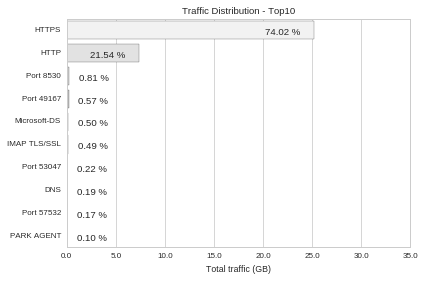

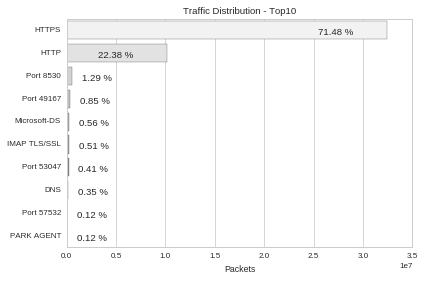

In [4]:
# traffic distribution (horizontal bars per port, x-axis pkts or bytes)
ses = Session()

totalbytes = ses.query(
        func.sum(DeviceAppTraffic.bytes_in)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).scalar() + ses.query(
        func.sum(DeviceAppTraffic.bytes_out)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).scalar()
    
totalpkts = ses.query(
        func.sum(DeviceAppTraffic.packets_in)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).scalar() + ses.query(
        func.sum(DeviceAppTraffic.packets_out)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).scalar()

q = ses.query(DeviceAppTraffic.dstport, 
              DeviceAppTraffic.service, 
              func.sum(DeviceAppTraffic.bytes_in), 
              func.sum(DeviceAppTraffic.bytes_out), 
              func.sum(DeviceAppTraffic.packets_in), 
              func.sum(DeviceAppTraffic.packets_out)).filter(
                DeviceAppTraffic.devid.in_(selecteddevs)).group_by(
                    DeviceAppTraffic.dstport, 
                    DeviceAppTraffic.service).order_by(DeviceAppTraffic.dstport)
              
traffic = defaultdict(list)
for row in q.all():
    traffic['port'].append(row[0])
    traffic['service'].append(str(row[1]))
    traffic['bytes_in'].append(row[2])
    traffic['bytes_out'].append(row[3])
    traffic['pkts_in'].append(row[4])
    traffic['pkts_out'].append(row[5])
    traffic['bytes'].append(row[2]+row[3])
    traffic['pkts'].append(row[4]+row[5])
    traffic['bytesf'].append((row[2]+row[3])*100.0/totalbytes)
    traffic['pktsf'].append((row[4]+row[5])*100.0/totalpkts)

tdf = pd.DataFrame(traffic)

# by byte count
tdf1 = tdf.sort_values('bytes', ascending=False)
tdf1 = tdf1.head(10)
tdf1['rank'] = list(range(10))

labels = []
for i in range(10):
    if (tdf1.iloc[i]['service'] != ''):
        if (tdf1.iloc[i]['port']==80):
            labels.append("HTTP")
        elif (tdf1.iloc[i]['port']==443):
            labels.append("HTTPS")
        elif (tdf1.iloc[i]['port']==993):
            labels.append("IMAP TLS/SSL")
        elif (tdf1.iloc[i]['port']==53):
            labels.append("DNS")
        else:
            labels.append(tdf1.iloc[i]['service'])
    else:
        labels.append("Port %d"%tdf1.iloc[i]['port']) 

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=tdf1, x='bytes', y='rank', ax=ax1, orient='h', palette=revpalette)

for i in range(2):
    ax1.text(tdf1.iloc[i]['bytes']-0.5*1e10, i+0.2, '%1.2f %%'%(tdf1.iloc[i]['bytesf']))
for i in range(2,10,1):
    ax1.text(tdf1.iloc[i]['bytes']+1e9, i+0.2, '%1.2f %%'%(tdf1.iloc[i]['bytesf']))

ax1.set_ylabel("")
ax1.set_yticklabels(labels)

ax1.set_xlabel("Total traffic (GB)")
ax1.set_xticks([y*1e10 for y in np.arange(0.0,4.0,0.5)])
ax1.set_xticklabels([y*1e1 for y in np.arange(0.0,4.0,0.5)])

ax1.set_title("Traffic Distribution - Top10")
plt.tight_layout()

f.savefig("../figs/trafficdistbytes.eps")

# by packet count
tdf2 = tdf.sort_values('pkts', ascending=False)
tdf2 = tdf2.head(10)
tdf2['rank'] = list(range(10))

labels = []
for i in range(10):
    if (tdf1.iloc[i]['service'] != ''):
        if (tdf1.iloc[i]['port']==80):
            labels.append("HTTP")
        elif (tdf1.iloc[i]['port']==443):
            labels.append("HTTPS")
        elif (tdf1.iloc[i]['port']==993):
            labels.append("IMAP TLS/SSL")
        elif (tdf1.iloc[i]['port']==53):
            labels.append("DNS")
        else:
            labels.append(tdf1.iloc[i]['service'])
    else:
        labels.append("Port %d"%tdf1.iloc[i]['port']) 

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=tdf2, x='pkts', y='rank', ax=ax1, orient='h', palette=revpalette)

for i in range(2):
    ax1.text(tdf2.iloc[i]['pkts']-0.7*1e7, i+0.2, '%1.2f %%'%(tdf2.iloc[i]['pktsf']))
for i in range(2,10,1):
    ax1.text(tdf2.iloc[i]['pkts']+1e6, i+0.2, '%1.2f %%'%(tdf2.iloc[i]['pktsf']))

ax1.set_ylabel("")
ax1.set_yticklabels(labels)
ax1.set_xlabel("Packets")
ax1.set_title("Traffic Distribution - Top10")
plt.tight_layout()

f.savefig("../figs/trafficdistpkts.eps")

ses.close()

### Take Aways

* http and https dominate in bytes + pkts

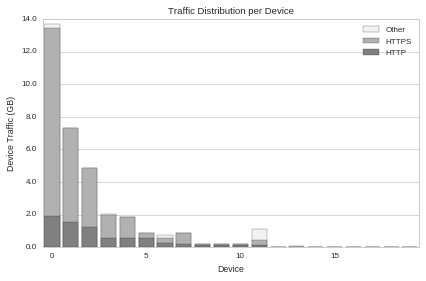

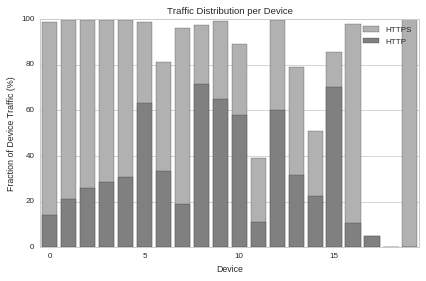

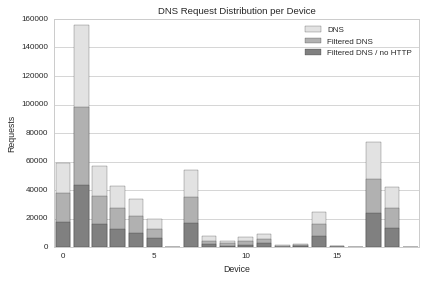

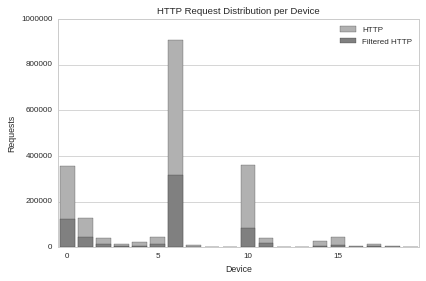

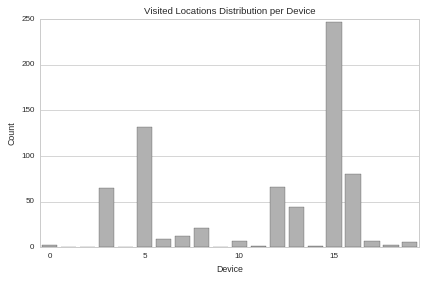

In [45]:
ses = Session()

# get total traffic per device
devtotals = defaultdict(lambda : defaultdict(float))

q = ses.query(DeviceAppTraffic.devid, 
              func.sum(DeviceAppTraffic.bytes_in), 
              func.sum(DeviceAppTraffic.bytes_out), 
              func.sum(DeviceAppTraffic.packets_in), 
              func.sum(DeviceAppTraffic.packets_out)).filter(
                 DeviceAppTraffic.devid.in_(selecteddevs)).group_by(DeviceAppTraffic.devid)
for row in q.all():
    if (row[3]+row[4]==0):
        continue
    devtotals[str(row[0])]['bytes'] = row[1]+row[2]*1.0
    devtotals[str(row[0])]['pkts'] = row[3]+row[4]*1.0

# HTTP traffic per device
q = ses.query(DeviceAppTraffic.devid, 
              func.sum(DeviceAppTraffic.bytes_in), 
              func.sum(DeviceAppTraffic.bytes_out), 
              func.sum(DeviceAppTraffic.packets_in), 
              func.sum(DeviceAppTraffic.packets_out)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).filter(
                or_(DeviceAppTraffic.dstport==80, 
                    DeviceAppTraffic.srcport==80)).group_by(
                        DeviceAppTraffic.devid)
              
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['bytes_80'] = row[1]+row[2]*1.0
    devtotals[devid]['pkts_80'] = row[3]+row[4]*1.0

# HTTPS traffic per device
q = ses.query(DeviceAppTraffic.devid, 
              func.sum(DeviceAppTraffic.bytes_in), 
              func.sum(DeviceAppTraffic.bytes_out), 
              func.sum(DeviceAppTraffic.packets_in), 
              func.sum(DeviceAppTraffic.packets_out)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).filter(
                or_(DeviceAppTraffic.dstport==443, 
                    DeviceAppTraffic.srcport==443)).group_by(
                        DeviceAppTraffic.devid)
              
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['bytes_443'] = row[1]+row[2]*1.0
    devtotals[devid]['pkts_443'] = row[3]+row[4]*1.0

# DNS reqs (all) per device
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_all'] = row[1]*1.0

# filtered DNS reqs
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).filter(
                    DnsReq.user_req==True).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_filt1'] = row[1]*1.0
    
    
# filtered DNS reqs
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).filter(
                    DnsReq.user_req==True).filter(DnsReq.duplicate==False).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_filt2'] = row[1]*1.0
    
    
    
# HTTP reqs (all) per device
q = ses.query(HttpReq.devid, 
              func.count(HttpReq.devid)).filter(HttpReq.devid.in_(selecteddevs)).group_by(
                        HttpReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['http_all'] = row[1]*1.0

# filtered HTTP reqs
q = ses.query(HttpReq.devid, 
              func.count(HttpReq.devid)).filter(HttpReq.devid.in_(selecteddevs)).filter(
                    HttpReq.user_url==True).group_by(HttpReq.devid)              
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['http_filt'] = row[1]*1.0    

# Unique locations
q = ses.query(Location.devid, func.count(func.distinct(Location.name))).filter(
        Location.devid.in_(selecteddevs),Location.overlap==False).group_by(Location.devid)  
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['locs'] = row[1]*1.0

devtypes = {}
q = ses.query(Device.id, Device.devtype).filter(
        Location.devid.in_(selecteddevs))
for row in q.all():
    devid = str(row[0])
    devtypes[devid] = row[1]
    
ses.close()

# group by device
devtraffic = defaultdict(list)
for devid in devtotals.keys():
    if (devtotals[devid]['bytes']<=0):
        continue
        
    devtraffic['devid'].append(devid)
    devtraffic['devtype'].append(devtypes[devid])
              
    devtraffic['locs'].append(devtotals[devid]['locs'])
              
    devtraffic['dns_all'].append(devtotals[devid]['dns_all'])
    devtraffic['dns_filt1'].append(devtotals[devid]['dns_filt1'])
    devtraffic['dns_filt2'].append(devtotals[devid]['dns_filt2'])
    
    devtraffic['dns_filtcum'].append(devtotals[devid]['dns_filt1']+devtotals[devid]['dns_filt2'])
    devtraffic['dns_allcum'].append(devtotals[devid]['dns_filt1']+devtotals[devid]['dns_filt2']+devtotals[devid]['dns_all'])
    
    devtraffic['http_all'].append(devtotals[devid]['http_all'])
    devtraffic['http_filt'].append(devtotals[devid]['http_filt'])
    devtraffic['http_allcum'].append(devtotals[devid]['http_filt']+devtotals[devid]['http_all'])

    webbytes = devtotals[devid]['bytes_443']+devtotals[devid]['bytes_80']
    
    devtraffic['bytes'].append(devtotals[devid]['bytes'])
    devtraffic['webbytes'].append(webbytes)
    devtraffic['httpbytes'].append(devtotals[devid]['bytes_80'])
    devtraffic['httpsbytes'].append(devtotals[devid]['bytes_443'])
    
    devtraffic['otherbytesf'].append(100.0*((devtotals[devid]['bytes']-(devtotals[devid]['bytes_443']+devtotals[devid]['bytes_80']))/devtotals[devid]['bytes']))
    devtraffic['webbytesf'].append(100.0*(webbytes/devtotals[devid]['bytes']))
    devtraffic['httpbytesf'].append(100.0*(devtotals[devid]['bytes_80']/devtotals[devid]['bytes']))
    devtraffic['httpsbytesf'].append(100.0*(devtotals[devid]['bytes_443']/devtotals[devid]['bytes']))

tdf3 = pd.DataFrame(devtraffic)

tdf3 = tdf3.sort_values('httpbytes', ascending=False)
tdf3['rank'] = list(range(len(devtraffic['devid'])))

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=tdf3, x='rank', y='bytes', ax=ax1, orient='v', color=palette[-1], label="Other")
sns.barplot(data=tdf3, x='rank', y='webbytes', ax=ax1, orient='v', color=palette[3], label="HTTPS")
sns.barplot(data=tdf3, x='rank', y='httpbytes', ax=ax1, orient='v', color=palette[0], label="HTTP")

ax1.set_ylabel("Device Traffic (GB)")
ax1.set_yticks([y*1e10 for y in np.arange(0.0,1.6,0.2)])
ax1.set_yticklabels([y*1e1 for y in np.arange(0.0,1.6,0.2)])

ax1.set_xticks(range(0,len(devtraffic['devid']),5))
ax1.set_xticklabels(range(0,len(devtraffic['devid']),5))
ax1.set_xlabel("Device")

ax1.set_title("Traffic Distribution per Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/trafficdistdevabs.eps")

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=tdf3, x='rank', y='webbytesf', ax=ax1, orient='v', color=palette[3], label="HTTPS")
sns.barplot(data=tdf3, x='rank', y='httpbytesf', ax=ax1, orient='v', color=palette[0], label="HTTP")

ax1.set_ylabel("Fraction of Device Traffic (%)")
ax1.set_xticks(range(0,len(devtraffic['devid']),5))
ax1.set_xticklabels(range(0,len(devtraffic['devid']),5))
ax1.set_xlabel("Device")
ax1.set_title("Traffic Distribution per Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/trafficdistdevfrac.eps")

# DNS reqs
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=tdf3, x='rank', y='dns_allcum', ax=ax1, orient='v', color=palette[6], label="DNS")
sns.barplot(data=tdf3, x='rank', y='dns_filtcum', ax=ax1, orient='v', color=palette[3], label="Filtered DNS")
sns.barplot(data=tdf3, x='rank', y='dns_filt2', ax=ax1, orient='v', color=palette[0], label="Filtered DNS / no HTTP")

ax1.set_ylabel("Requests")
ax1.set_xticks(range(0,len(devtraffic['devid']),5))
ax1.set_xticklabels(range(0,len(devtraffic['devid']),5))
ax1.set_xlabel("Device")
ax1.set_title("DNS Request Distribution per Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/dnsdistdev.eps")


# HTTP reqs
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=tdf3, x='rank', y='http_allcum', ax=ax1, orient='v', color=palette[3], label="HTTP")
sns.barplot(data=tdf3, x='rank', y='http_filt', ax=ax1, orient='v', color=palette[0], label="Filtered HTTP")

ax1.set_ylabel("Requests")
ax1.set_xticks(range(0,len(devtraffic['devid']),5))
ax1.set_xticklabels(range(0,len(devtraffic['devid']),5))
ax1.set_xlabel("Device")
ax1.set_title("HTTP Request Distribution per Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/httpdistdev.eps")
              
              
# Unique locations
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=tdf3, x='rank', y='locs', ax=ax1, orient='v', color=palette[3], label="HTTP")

ax1.set_ylabel("Count")
ax1.set_xticks(range(0,len(devtraffic['devid']),5))
ax1.set_xticklabels(range(0,len(devtraffic['devid']),5))
ax1.set_xlabel("Device")
ax1.set_title("Visited Locations Distribution per Device")
#ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/locdistdev.eps")              

### Take Aways

Note device order is the same across the plots (by total bytes)

* http+https are the prevalent protocols also across devices (1st+2nd plot)
* https dominates on most devices
* outliers (i.e. devs with not that much web traffic) were not very active in any case (1st vs 2nd plot)
* about DNS + HTTP, makes sense to combine the sources: DNS comes from pcaps, HTTP was captured independently, we may miss one of the other, DNS contains https domains aswell, can filter out DNS reqs that have a matching HTTP req (to avoid double counts)

In [6]:
ses = Session()

# uid => total traffic
usertraffic = {}
for uid in devsperuser:
    usertraffic[uid] = 0.0
    
    q = ses.query(func.sum(DeviceAppTraffic.bytes_in), 
                  func.sum(DeviceAppTraffic.bytes_out), 
                  func.sum(DeviceAppTraffic.packets_in), 
                  func.sum(DeviceAppTraffic.packets_out)).filter(
                    DeviceAppTraffic.devid.in_(devsperuser[uid]))

    for row in q.all():
        if (row[0]==None or row[1]==None or row[0]+row[1]==0):
            continue
        usertraffic[uid] += row[0]*1.0
        usertraffic[uid] += row[1]*1.0
        
ses.close()
print usertraffic.keys()

[2, 3, 4, 5, 7, 8, 13, 15, 18, 21, 22, 23]


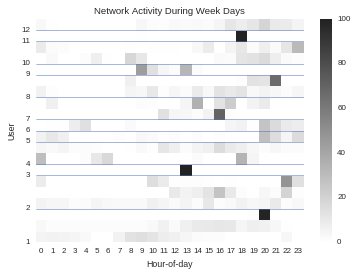

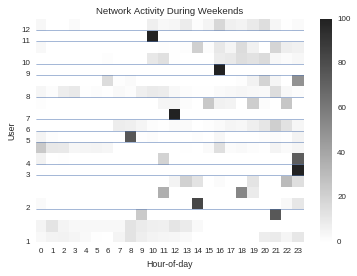

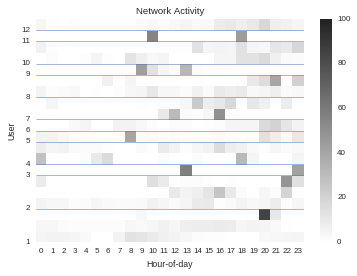

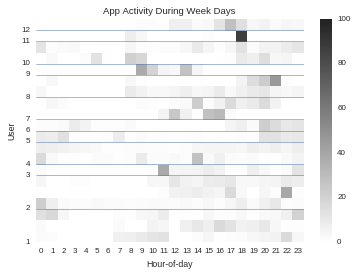

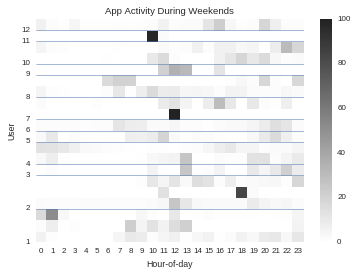

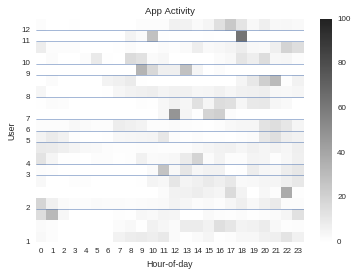

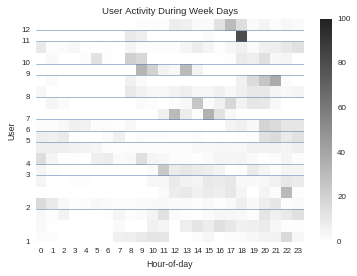

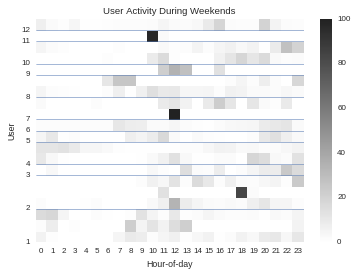

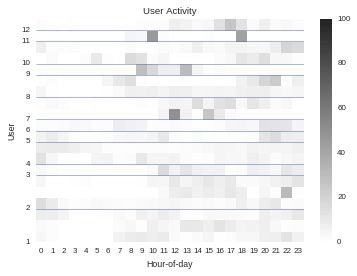

In [84]:
ses = Session()

cmap = sns.dark_palette("#ffffff", as_cmap=True, reverse=True)

# minutes
BINSIZE=60
        
weekdata = []
wedata = []
alldata = []

yticks = []
yidx = 0

ignoreddevs = {}

for uid in sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True):
    yticks.append(yidx)
    
    for devid in devsperuser[uid]:
        weektotal = 0.0
        wetotal = 0.0
        alltotal = 0.0
        weekdays = {}
        weekend = {}
        alldays = {}
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            weekdays[k] = 0.0
            weekend[k] = 0.0
            alldays[k] = 0.0

        q = ses.query(DeviceAppTraffic.ts, 
                      DeviceAppTraffic.bytes_in, 
                      DeviceAppTraffic.bytes_out).filter(
                        DeviceAppTraffic.devid==devid)

        for (ts,byin,byout) in q.all():
            bytes = 0
            if (byin!=None):
                bytes += byin
            if (byout!=None):
                bytes += byout

            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE

            if (ts.weekday() == 5 or ts.weekday() == 6):
                weekend[binidx] += bytes
                wetotal += bytes
            else:
                weekdays[binidx] += bytes
                weektotal += bytes

            alldays[binidx] += bytes
            alltotal += bytes

        if (alltotal==0):
            ignoreddevs[devid] = True
            continue
        yidx += 1
            
        # to % of bytes
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            if (weektotal>0):
                weekdays[k] = 100.0*(weekdays[k]*1.0/weektotal)
            if (wetotal>0):
                weekend[k] = 100.0*(weekend[k]*1.0/wetotal)
            if (alltotal>0):
                alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

        weekdata.append(weekdays.values())
        wedata.append(weekend.values())
        alldata.append(alldays.values())

def doplot(data,title,fname=None):
    f, ax = plt.subplots(1, 1, figsize=(6, 4))        
    ax = sns.heatmap(data, 
                     cmap=cmap,
                     vmin=0, 
                     vmax=100.0, 
                     yticklabels=False)
    ax.set_title("%s"%title)
    ax.set_xlabel("Hour-of-day")
    
    ax.set_ylabel("User")
    ax.yaxis.set_ticks(yticks)
    ax.set_yticklabels([i+1 for i in range(len(yticks))])
    for ymaj in ax.yaxis.get_majorticklocs():
        ax.axhline(y=ymaj,ls='-',lw=0.5, color='b')

    plt.show()
    
    if (fname!=None):
        f.savefig(fname)

doplot(weekdata, "Network Activity During Week Days", "../figs/heatmap_traffic_week.eps")
doplot(wedata, "Network Activity During Weekends", "../figs/heatmap_traffic_weekend.eps")
doplot(alldata, "Network Activity", "../figs/heatmap_traffic_any.eps")

# App (DNS+HTTP) Activity Heatmap [weekday|weekend]: x: time-of-day, y: user, intensity: % of reqs (from this user)
weekdata = []
wedata = []
alldata = []

for uid in sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True):
    for devid in devsperuser[uid]:                
        if (devid in ignoreddevs):
            continue
        weektotal = 0.0
        wetotal = 0.0
        alltotal = 0.0
        weekdays = {}
        weekend = {}
        alldays = {}
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            weekdays[k] = 0.0
            weekend[k] = 0.0
            alldays[k] = 0.0
        
        q = ses.query(HttpReq.ts).filter(
                        HttpReq.devid==devid)    
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE

            if (ts.weekday() == 5 or ts.weekday() == 6):
                weekend[binidx] += 1
                wetotal += 1
            else:
                weekdays[binidx] += 1
                weektotal += 1

            alldays[binidx] += 1
            alltotal += 1

        q = ses.query(DnsReq.ts).filter(
                        DnsReq.devid==devid).filter(DnsReq.duplicate==False) 
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE

            if (ts.weekday() == 5 or ts.weekday() == 6):
                weekend[binidx] += 1
                wetotal += 1
            else:
                weekdays[binidx] += 1
                weektotal += 1

            alldays[binidx] += 1
            alltotal += 1
                
        # to % of bytes
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            if (weektotal>0):
                weekdays[k] = 100.0*(weekdays[k]*1.0/weektotal)
            if (wetotal>0):
                weekend[k] = 100.0*(weekend[k]*1.0/wetotal)
            if (alltotal>0):
                alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

        weekdata.append(weekdays.values())
        wedata.append(weekend.values())
        alldata.append(alldays.values())
        
doplot(weekdata, "App Activity During Week Days", "../figs/heatmap_appact_week.eps")
doplot(wedata, "App Activity During Weekends", "../figs/heatmap_appact_weekend.eps")
doplot(alldata, "App Activity", "../figs/heatmap_appact_any.eps")

# App (DNS+HTTP) Activity Heatmap [weekday|weekend]: x: time-of-day, y: user, intensity: % of reqs (from this user)
weekdata = []
wedata = []
alldata = []

for uid in sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True):
    for devid in devsperuser[uid]:                
        if (devid in ignoreddevs):
            continue
        weektotal = 0.0
        wetotal = 0.0
        alltotal = 0.0
        weekdays = {}
        weekend = {}
        alldays = {}
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            weekdays[k] = 0.0
            weekend[k] = 0.0
            alldays[k] = 0.0
        
        q = ses.query(HttpReq.ts).filter(
                        HttpReq.devid==devid).filter(
                        HttpReq.user_url==True)    
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE

            if (ts.weekday() == 5 or ts.weekday() == 6):
                weekend[binidx] += 1
                wetotal += 1
            else:
                weekdays[binidx] += 1
                weektotal += 1

            alldays[binidx] += 1
            alltotal += 1

        q = ses.query(DnsReq.ts).filter(
                        DnsReq.devid==devid).filter(
                        DnsReq.user_req==True, DnsReq.duplicate==False) 
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE

            if (ts.weekday() == 5 or ts.weekday() == 6):
                weekend[binidx] += 1
                wetotal += 1
            else:
                weekdays[binidx] += 1
                weektotal += 1

            alldays[binidx] += 1
            alltotal += 1
                
        # to % of bytes
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            if (weektotal>0):
                weekdays[k] = 100.0*(weekdays[k]*1.0/weektotal)
            if (wetotal>0):
                weekend[k] = 100.0*(weekend[k]*1.0/wetotal)
            if (alltotal>0):
                alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

        weekdata.append(weekdays.values())
        wedata.append(weekend.values())
        alldata.append(alldays.values())
        
doplot(weekdata, "User Activity During Week Days", "../figs/heatmap_useract_week.eps")
doplot(wedata, "User Activity During Weekends", "../figs/heatmap_useract_weekend.eps")
doplot(alldata, "User Activity", "../figs/heatmap_useract_any.eps")

ses.close()

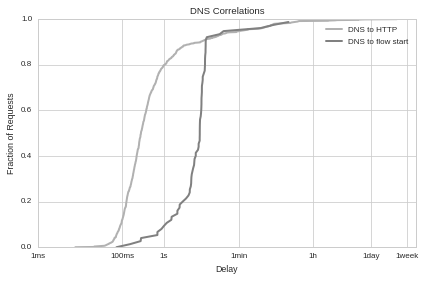

In [85]:
# IP address validation
rexp = re.compile('\d+\.\d+.\d+.\d+')

# DNS
#    correlation of connection with non-recently-DNS-requested name

ses = Session()

# -> delay from dns req to first 'matching' HTTP req (domain name match)
dnstofirsthttp = {}

# -> delay from dns req to first 'matching' pkt (IP match)
dnstofirstpkt = {}

for devid in selecteddevs:     
    dnsreqs = ses.query(DnsReq.id, DnsReq.ts, DnsReq.query, DnsReq.ans_ttl, DnsReq.ans_addr).filter(
        DnsReq.devid==devid).order_by(DnsReq.query, DnsReq.ts).all()
    
    total = len(dnsreqs)
    if (total == 0):
        continue
    
    # upwrap IPs from the response
    dnsreqs2 = []
    for (reqid,ts,query,ttls,addrs) in dnsreqs:
        for i,a in enumerate(addrs):
            if (rexp.match(a) == None):
                continue
            ttl = None
            if (i < len(ttls)):
                ttl = ttls[i]
            elif (len(ttls)==1):
                ttl = ttls[0]                
            dnsreqs2.append((reqid,ts,a,ttl))
    dnsreqs2 = sorted(dnsreqs2, key=lambda x: int(ipaddress.IPv4Address(x[2])))
    
    httpreqs = ses.query(HttpReq.ts, HttpReq.req_url_host).filter(
        HttpReq.devid==devid).order_by(HttpReq.req_url_host, HttpReq.ts).all()    
    
    devtraffic = ses.query(DeviceAppTraffic.ts, DeviceAppTraffic.dstip).filter(
        DeviceAppTraffic.devid==devid).order_by(
            DeviceAppTraffic.dstip, DeviceAppTraffic.ts).all()    
    
    # sample first 1000 reqs
    l = min(len(dnsreqs),1000)
    for (reqid,ts,domain,ttls,addrs) in dnsreqs[:l]:
        dnstofirsthttp[reqid] = -1
        
        # rewind to the matching domain in the sorted http reqs
        while (len(httpreqs) > 0 and httpreqs[0][1] < domain):
            httpreqs.pop(0)
            
        # find the matching http req
        if (len(httpreqs)>0 and httpreqs[0][1] == domain):
            # rewind to the next possible http req
            while (len(httpreqs)>0 and httpreqs[0][0]<ts):
                httpreqs.pop(0)
                
            if (len(httpreqs)>0):
                delay = (httpreqs[0][0] - ts).total_seconds()
                if (ttls==None or len(ttls)==0 or delay<=ttls[0]):
                    dnstofirsthttp[reqid] = delay
                    httpreqs.pop(0)            
    
    # sample first 1000 reqs
    l = min(len(dnsreqs2),1000)    
    for (reqid,ts,addr,ttl) in dnsreqs2[:l]:
        dnstofirstpkt[reqid] = -1

        # rewind to the matching IP in the sorted traffic
        while (len(devtraffic) > 0 and (rexp.match(devtraffic[0][1])==None or ipaddress.IPv4Address(devtraffic[0][1]) < ipaddress.IPv4Address(addr))):
            devtraffic.pop(0)

        # find the matching traffic
        if (len(devtraffic)>0 and ipaddress.IPv4Address(devtraffic[0][1]) == ipaddress.IPv4Address(addr)):
            # rewind to the next possible traffic time
            while (len(devtraffic)>0 and devtraffic[0][0]<ts):
                devtraffic.pop(0)

            if (len(devtraffic)>0):
                delay = (devtraffic[0][0] - ts).total_seconds()
                if (ttl==None or delay<=ttl):
                    dnstofirstpkt[reqid] = delay
                    devtraffic.pop(0)                                

f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf([v for v in dnstofirsthttp.values() if v >= 0])
ax1.plot(x,y, '-', lw=2, c=palette[3], label="DNS to HTTP")

(x,y) = datautils.aecdf([v for v in dnstofirstpkt.values() if v >= 0])
ax1.plot(x,y, '-', lw=2, c=palette[0], label="DNS to flow start")

ax1.set_title('DNS Correlations') 
ax1.set_ylabel('Fraction of Requests')
ax1.set_xscale('log')
ax1.set_xlabel('Delay')
ax1.set_xticks([0.001, 0.1,1, 60, 3600, 24*3600, 7*24*3600])
ax1.set_xticklabels(['1ms','100ms','1s','1min','1h','1day','1week'])
ax1.legend(loc='best')

plt.tight_layout()
plt.show()

ses.close()

### Take Away

* I used a 1-minute cut-off for filtering dns reqs that are followed by a matching http (to avoid double counting)
* Justified (roughly) by this graph, 0.95 of dns reqs followed by a http do so in <= 1min (and are thus probably linked)

In [95]:
# IP address validation
rexp = re.compile('\d+\.\d+.\d+.\d+')

# DNS
#    correlation of connection with non-recently-DNS-requested name

ses = Session()

# -> delay from dns req to first 'matching' HTTP req (domain name match)
dnstohttp = {}

# -> delay from dns req to first 'matching' pkt (IP match)
dnstopkt = {}

for devid in selecteddevs:     
    dnsreqs = ses.query(DnsReq.id, DnsReq.ts, DnsReq.query, DnsReq.ans_ttl, DnsReq.ans_addr).filter(
        DnsReq.devid==devid).order_by(DnsReq.query, DnsReq.ts).all()
    
    total = len(dnsreqs)
    if (total == 0):
        continue
    
    # upwrap IPs from the response
    dnsreqs2 = []
    for (reqid,ts,query,ttls,addrs) in dnsreqs:
        for i,a in enumerate(addrs):
            if (rexp.match(a) == None):
                continue
            ttl = None
            if (i < len(ttls)):
                ttl = ttls[i]
            elif (len(ttls)==1):
                ttl = ttls[0]                
            dnsreqs2.append((reqid,ts,a,ttl))
    dnsreqs2 = sorted(dnsreqs2, key=lambda x: int(ipaddress.IPv4Address(x[2])))
    
    httpreqs = ses.query(HttpReq.ts, HttpReq.req_url_host).filter(
        HttpReq.devid==devid).order_by(HttpReq.req_url_host, HttpReq.ts).all()    
    
    devtraffic = ses.query(DeviceAppTraffic.ts, DeviceAppTraffic.dstip).filter(
        DeviceAppTraffic.devid==devid).order_by(
            DeviceAppTraffic.dstip, DeviceAppTraffic.ts).all()    
    
    # sample first 1000 reqs
    l = min(len(dnsreqs),1000)
    for (reqid,ts,domain,ttls,addrs) in dnsreqs[:l]:
        dnstofirsthttp[reqid] = -1
        
        # rewind to the matching domain in the sorted http reqs
        while (len(httpreqs) > 0 and httpreqs[0][1] < domain):
            httpreqs.pop(0)
            
        # find the matching http req
        if (len(httpreqs)>0 and httpreqs[0][1] == domain):
            # rewind to the next possible http req
            while (len(httpreqs)>0 and httpreqs[0][0]<ts):
                httpreqs.pop(0)
                
            if (len(httpreqs)>0):
                delay = (httpreqs[0][0] - ts).total_seconds()
                if (ttls==None or len(ttls)==0 or delay<=ttls[0]):
                    dnstofirsthttp[reqid] = delay
                    httpreqs.pop(0)            
    
    # sample first 1000 reqs
    l = min(len(dnsreqs2),1000)    
    for (reqid,ts,addr,ttl) in dnsreqs2[:l]:
        dnstofirstpkt[reqid] = -1

        # rewind to the matching IP in the sorted traffic
        while (len(devtraffic) > 0 and (rexp.match(devtraffic[0][1])==None or ipaddress.IPv4Address(devtraffic[0][1]) < ipaddress.IPv4Address(addr))):
            devtraffic.pop(0)

        # find the matching traffic
        if (len(devtraffic)>0 and ipaddress.IPv4Address(devtraffic[0][1]) == ipaddress.IPv4Address(addr)):
            # rewind to the next possible traffic time
            while (len(devtraffic)>0 and devtraffic[0][0]<ts):
                devtraffic.pop(0)

            if (len(devtraffic)>0):
                delay = (devtraffic[0][0] - ts).total_seconds()
                if (ttl==None or delay<=ttl):
                    dnstofirstpkt[reqid] = delay
                    devtraffic.pop(0)                                

f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf([v for v in dnstofirsthttp.values() if v >= 0])
ax1.plot(x,y, '-', lw=2, c=palette[3], label="DNS to HTTP")

(x,y) = datautils.aecdf([v for v in dnstofirstpkt.values() if v >= 0])
ax1.plot(x,y, '-', lw=2, c=palette[0], label="DNS to flow start")

ax1.set_title('DNS Correlations') 
ax1.set_ylabel('Fraction of Requests')
ax1.set_xscale('log')
ax1.set_xlabel('Delay')
ax1.set_xticks([0.001, 0.1,1, 60, 3600, 24*3600, 7*24*3600])
ax1.set_xticklabels(['1ms','100ms','1s','1min','1h','1day','1week'])
ax1.legend(loc='best')

plt.tight_layout()
plt.show()

ses.close()

KeyboardInterrupt: 

In [7]:
# construct top-x locations per traffic,app,user for each user

# uid => location => bytes
trafficperloc = {}

# uid => location => dns+http reqs
appperloc = {}

# uid => location => user reqs
userperloc = {}

ses = Session()
for uid in sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True):
    for devid in devsperuser[uid]:
        trafficperloc[devid] = defaultdict(long)
        appperloc[devid] = defaultdict(long)
        userperloc[devid] = defaultdict(long)
        
    q = ses.query(func.sum(DeviceAppTraffic.bytes_in+DeviceAppTraffic.bytes_out),
                     Location.name, Location.devid).join(Location,
                        and_(DeviceAppTraffic.devid==Location.devid,
                             DeviceAppTraffic.ts>=Location.entertime,
                             DeviceAppTraffic.ts<=Location.exittime)).filter(
                                Location.devid.in_(devsperuser[uid]),Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        trafficperloc[row[2]][loc] = row[0]

    q = ses.query(func.count(DnsReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(DnsReq.devid==Location.devid,
                             DnsReq.ts>=Location.entertime,
                             DnsReq.ts<=Location.exittime)).filter(
                                Location.devid.in_(devsperuser[uid]),Location.overlap==False).group_by(Location.name, Location.devid)
    
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        appperloc[row[2]][loc] += row[0]
        
    q = ses.query(func.count(HttpReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(HttpReq.devid==Location.devid,
                             HttpReq.ts>=Location.entertime,
                             HttpReq.ts<=Location.exittime)).filter(
                                Location.devid.in_(devsperuser[uid]),Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        appperloc[row[2]][loc] += row[0]

        
    q = ses.query(func.count(DnsReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(DnsReq.devid==Location.devid,
                             DnsReq.ts>=Location.entertime,
                             DnsReq.ts<=Location.exittime)).filter(
                                DnsReq.devid.in_(devsperuser[uid]),
                                DnsReq.user_req==True,
                                DnsReq.duplicate==False,
                                Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        userperloc[row[2]][loc] += row[0]
        
    q = ses.query(func.count(HttpReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(HttpReq.devid==Location.devid,
                             HttpReq.ts>=Location.entertime,
                             HttpReq.ts<=Location.exittime)).filter(
                                HttpReq.devid.in_(devsperuser[uid]),
                                HttpReq.user_url==True,
                                Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        userperloc[row[2]][loc] += row[0]
ses.close()

aloco 20
bytes 20
devid 20
tloc3 20
tloc2 20
tloc1 20
tloco 20
uloco 20
uloc2 20
uloc3 20
uloc1 20
aloc2 20
aloc3 20
aloc1 20


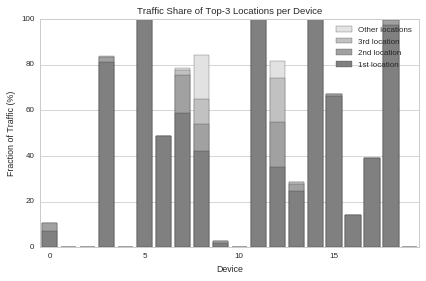

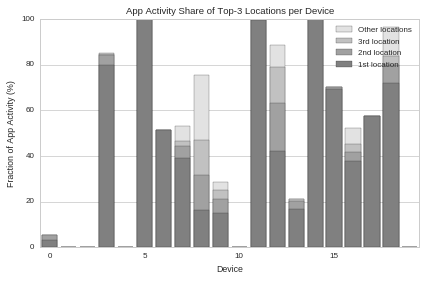

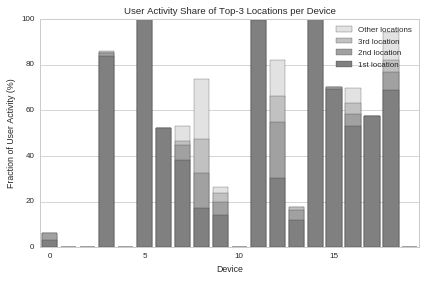

In [14]:
# LOCATION:

ses = Session()

# get total traffic per device
devtotals = defaultdict(lambda : defaultdict(float))

q = ses.query(DeviceAppTraffic.devid, 
              func.sum(DeviceAppTraffic.bytes_in), 
              func.sum(DeviceAppTraffic.bytes_out), 
              func.sum(DeviceAppTraffic.packets_in), 
              func.sum(DeviceAppTraffic.packets_out)).filter(
                 DeviceAppTraffic.devid.in_(selecteddevs)).group_by(DeviceAppTraffic.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['bytes'] = row[1]+row[2]*1.0
    devtotals[devid]['pkts'] = row[3]+row[4]*1.0

# DNS reqs (all) per device
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_all'] = row[1]*1.0

# filtered DNS reqs
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).filter(
                    DnsReq.user_req==True).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_filt1'] = row[1]*1.0
    
    
# filtered DNS reqs
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).filter(
                    DnsReq.user_req==True).filter(DnsReq.duplicate==False).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_filt2'] = row[1]*1.0
    
    
    
# HTTP reqs (all) per device
q = ses.query(HttpReq.devid, 
              func.count(HttpReq.devid)).filter(HttpReq.devid.in_(selecteddevs)).group_by(
                        HttpReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['http_all'] = row[1]*1.0

# filtered HTTP reqs
q = ses.query(HttpReq.devid, 
              func.count(HttpReq.devid)).filter(HttpReq.devid.in_(selecteddevs)).filter(
                    HttpReq.user_url==True).group_by(HttpReq.devid)              
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['http_filt'] = row[1]*1.0    
    

TOPX=3

#    correlation of location with device use
data = defaultdict(list)
for devid in selecteddevs:
    allbytes = devtotals[str(devid)]['bytes']
    allappbytes = devtotals[str(devid)]['dns_all']+devtotals[str(devid)]['http_all']
    alluserbytes = devtotals[str(devid)]['dns_filt2']+devtotals[str(devid)]['http_filt']
    if (allbytes == 0):
        continue
        
    data['devid'].append(devid)
    data['bytes'].append(allbytes)

    # if we've only ever seen a single location
    # from this device => assume stationary and flag all from that loc
    locs = ses.query(Location.name, func.count(Location.id)).filter(
            Location.devid==devid).group_by(Location.name).all()
    
    # top three traffic 
    if (len(locs)>1):    
        # been in more than one loc
        
        for i,loc in enumerate(sorted(trafficperloc[devid].keys(), key=lambda x : trafficperloc[devid][x], reverse=True)[:TOPX]):
            data['tloc%d'%(i+1)].append(100.0 * (trafficperloc[devid][loc]*1.0/allbytes))
        i = min(len(trafficperloc[devid]),3)
        while (i<3):
            data['tloc%d'%(i+1)].append(0.0)
            i += 1

        bc = 0.0
        for i,loc in enumerate(sorted(trafficperloc[devid].keys(), key=lambda x : trafficperloc[devid][x], reverse=True)[TOPX:]):
            bc += trafficperloc[devid][loc]*1.0
        data['tloco'].append(100.0*(bc/allbytes))

        # top three app
        for i,loc in enumerate(sorted(appperloc[devid].keys(), key=lambda x : appperloc[devid][x], reverse=True)[:TOPX]):
            data['aloc%d'%(i+1)].append(100.0 * (appperloc[devid][loc]*1.0/allappbytes))
        i = min(len(appperloc[devid]),3)
        while (i<3):
            data['aloc%d'%(i+1)].append(0.0)
            i += 1

        bc = 0.0
        for i,loc in enumerate(sorted(appperloc[devid].keys(), key=lambda x : appperloc[devid][x], reverse=True)[TOPX:]):
            bc += appperloc[devid][loc]*1.0
        data['aloco'].append(100.0*(bc/allappbytes))
            
            
        # top three user
        for i,loc in enumerate(sorted(userperloc[devid].keys(), key=lambda x : userperloc[devid][x], reverse=True)[:TOPX]):
            data['uloc%d'%(i+1)].append(100.0 * (userperloc[devid][loc]*1.0/alluserbytes))
        i = min(len(userperloc[devid]),3)
        while (i<3):
            data['uloc%d'%(i+1)].append(0.0)
            i += 1
        
        bc = 0.0
        for i,loc in enumerate(sorted(userperloc[devid].keys(), key=lambda x : userperloc[devid][x], reverse=True)[TOPX:]):
            bc += userperloc[devid][loc]*1.0
        data['uloco'].append(100.0*(bc/alluserbytes))
        
    elif (len(locs)==1):
        # single location device
        
        data['tloc1'].append(100.0)
        data['tloc2'].append(0.0)
        data['tloc3'].append(0.0)
        data['tloco'].append(0.0)
        
        data['aloc1'].append(100.0)
        data['aloc2'].append(0.0)
        data['aloc3'].append(0.0)
        data['aloco'].append(0.0)

        data['uloc1'].append(100.0)
        data['uloc2'].append(0.0)
        data['uloc3'].append(0.0)
        data['uloco'].append(0.0)
        
    else:
        # no loc
        
        data['tloco'].append(0.0)
        data['tloc1'].append(0.0)
        data['tloc2'].append(0.0)
        data['tloc3'].append(0.0)

        data['aloco'].append(0.0)
        data['aloc1'].append(0.0)
        data['aloc2'].append(0.0)
        data['aloc3'].append(0.0)

        data['uloco'].append(0.0)
        data['uloc1'].append(0.0)
        data['uloc2'].append(0.0)
        data['uloc3'].append(0.0)
        
#for k in data:
#    print k,len(data[k])
        
ldf = pd.DataFrame(data)
ldf = ldf.sort_values('bytes', ascending=False)
ldf['rank'] = list(range(len(data['devid'])))

# stacked fractions
ldf['tloc2st'] = ldf['tloc1']+ldf['tloc2']
ldf['tloc3st'] = ldf['tloc1']+ldf['tloc2']+ldf['tloc3']
ldf['tlocost'] = ldf['tloc1']+ldf['tloc2']+ldf['tloc3']+ldf['tloco']
ldf['tlocna'] = 100.0

ldf['aloc2st'] = ldf['aloc1']+ldf['aloc2']
ldf['aloc3st'] = ldf['aloc1']+ldf['aloc2']+ldf['aloc3']
ldf['alocost'] = ldf['aloc1']+ldf['aloc2']+ldf['aloc3']+ldf['aloco']
ldf['alocna'] = 100.0

ldf['uloc2st'] = ldf['uloc1']+ldf['uloc2']
ldf['uloc3st'] = ldf['uloc1']+ldf['uloc2']+ldf['uloc3']
ldf['ulocost'] = ldf['uloc1']+ldf['uloc2']+ldf['uloc3']+ldf['uloco']
ldf['ulocna'] = 100.0

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=ldf, x='rank', y='tlocost', ax=ax1, orient='v', color=palette[6], label="Other locations")
sns.barplot(data=ldf, x='rank', y='tloc3st', ax=ax1, orient='v', color=palette[4], label="3rd location")
sns.barplot(data=ldf, x='rank', y='tloc2st', ax=ax1, orient='v', color=palette[2], label="2nd location")
sns.barplot(data=ldf, x='rank', y='tloc1', ax=ax1, orient='v', color=palette[0], label="1st location")

ax1.set_ylabel("Fraction of Traffic (%)")
ax1.set_xticks(range(0,len(data['devid']),5))
ax1.set_xticklabels(range(0,len(data['devid']),5))
ax1.set_xlabel("Device")
ax1.set_title("Traffic Share of Top-3 Locations per Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/trafficlocdistdev.eps")              

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=ldf, x='rank', y='alocost', ax=ax1, orient='v', color=palette[6], label="Other locations")
sns.barplot(data=ldf, x='rank', y='aloc3st', ax=ax1, orient='v', color=palette[4], label="3rd location")
sns.barplot(data=ldf, x='rank', y='aloc2st', ax=ax1, orient='v', color=palette[2], label="2nd location")
sns.barplot(data=ldf, x='rank', y='aloc1', ax=ax1, orient='v', color=palette[0], label="1st location")

ax1.set_ylabel("Fraction of App Activity (%)")
ax1.set_xticks(range(0,len(data['devid']),5))
ax1.set_xticklabels(range(0,len(data['devid']),5))
ax1.set_xlabel("Device")
ax1.set_title("App Activity Share of Top-3 Locations per Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/applocdistdev.eps")              


f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(data=ldf, x='rank', y='ulocost', ax=ax1, orient='v', color=palette[6], label="Other locations")
sns.barplot(data=ldf, x='rank', y='uloc3st', ax=ax1, orient='v', color=palette[4], label="3rd location")
sns.barplot(data=ldf, x='rank', y='uloc2st', ax=ax1, orient='v', color=palette[2], label="2nd location")
sns.barplot(data=ldf, x='rank', y='uloc1', ax=ax1, orient='v', color=palette[0], label="1st location")

ax1.set_ylabel("Fraction of User Activity (%)")
ax1.set_xticks(range(0,len(data['devid']),5))
ax1.set_xticklabels(range(0,len(data['devid']),5))
ax1.set_xlabel("Device")
ax1.set_title("User Activity Share of Top-3 Locations per Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/userlocdistdev.eps")   

ses.close()

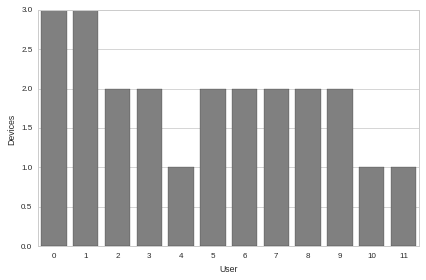

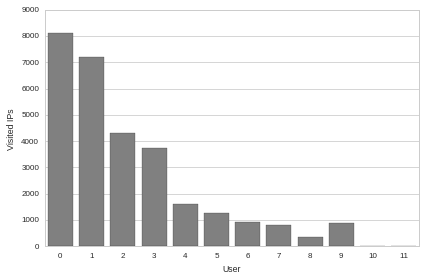

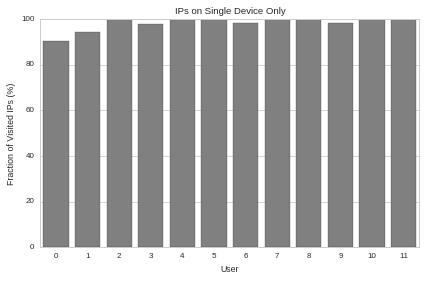

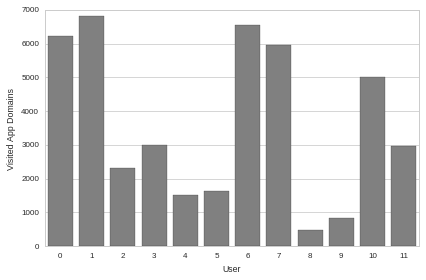

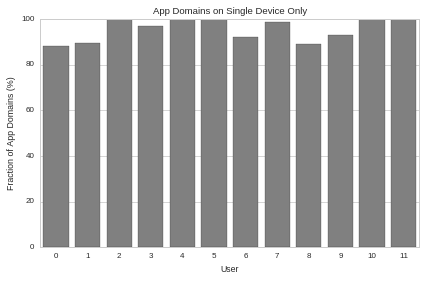

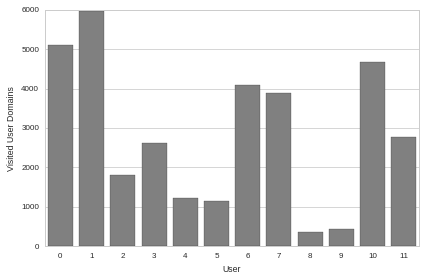

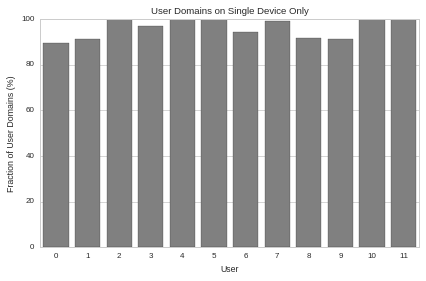

In [34]:
# CONTENT
from sqlalchemy import distinct
ses = Session()

# get unique ips, dns+http domains, user dns+http domains / user / device
data = defaultdict(list)
for rank,uid in enumerate(sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True)):
    uniqueips = defaultdict(set)
    uniqueapps = defaultdict(set)
    uniqueuser = defaultdict(set)    
    for devid in devsperuser[uid]:
        q = ses.query(distinct(DeviceAppTraffic.dstip)).filter(DeviceAppTraffic.devid==devid)
        uniqueips[devid] = set([r[0] for r in q.all()])

        q = ses.query(distinct(DnsReq.query)).filter(DnsReq.devid==devid)
        uniqueapps[devid] = set([r[0] for r in q.all()])

        q = ses.query(distinct(HttpReq.req_url_host)).filter(HttpReq.devid==devid)
        uniqueapps[devid] = uniqueapps[devid] | set([r[0] for r in q.all()])

        q = ses.query(distinct(DnsReq.query)).filter(
                DnsReq.devid==devid, DnsReq.user_req==True, DnsReq.duplicate==False)
        uniqueuser[devid] = set([r[0] for r in q.all()])

        q = ses.query(distinct(HttpReq.req_url_host)).filter(
                HttpReq.devid==devid, HttpReq.user_url==True)
        uniqueuser[devid] = uniqueuser[devid] | set([r[0] for r in q.all()])
        
    data['rank'].append(rank)
    data['devs'].append(len(devsperuser[uid]))
    
    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueips[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueips[devid2])
        c += len(s)
    data['ip'].append(100.0*(c*1.0/len(fulls)))
    data['ipcount'].append(len(fulls))

    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueapps[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueapps[devid2])
        c += len(s)
    data['app'].append(100.0*(c*1.0/len(fulls)))    
    data['appcount'].append(len(fulls))
    
    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueuser[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueuser[devid2])
        c += len(s)
    data['user'].append(100.0*(c*1.0/len(fulls)))    
    data['usercount'].append(len(fulls))
    
cdf = pd.DataFrame(data)
    
#    correlation of visits to sites on multiple devices
# => % of ips, app, user visited on single device / per user (100 for 1 dev users, for others ?)

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=cdf, x='rank', y='devs', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("Devices")
ax1.set_xlabel("User")
plt.tight_layout()
f.savefig("../figs/content_userdevs.eps")   

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=cdf, x='rank', y='ipcount', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("Visited IPs")
ax1.set_xlabel("User")
plt.tight_layout()
f.savefig("../figs/content_ips.eps")   

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=cdf, x='rank', y='ip', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("Fraction of Visited IPs (%)")
ax1.set_xlabel("User")
ax1.set_title("IPs on Single Device Only")
plt.tight_layout()
f.savefig("../figs/content_uniqueip.eps")   

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=cdf, x='rank', y='appcount', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("Visited App Domains")
ax1.set_xlabel("User")
plt.tight_layout()
f.savefig("../figs/content_apps.eps")   

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=cdf, x='rank', y='app', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("Fraction of App Domains (%)")
ax1.set_xlabel("User")
ax1.set_title("App Domains on Single Device Only")
plt.tight_layout()
f.savefig("../figs/content_uniqueapp.eps")   

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=cdf, x='rank', y='usercount', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("Visited User Domains")
ax1.set_xlabel("User")
plt.tight_layout()
f.savefig("../figs/content_user.eps")   

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=cdf, x='rank', y='user', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("Fraction of User Domains (%)")
ax1.set_xlabel("User")
ax1.set_title("User Domains on Single Device Only")
plt.tight_layout()
f.savefig("../figs/content_uniqueuser.eps")   

ses.close()

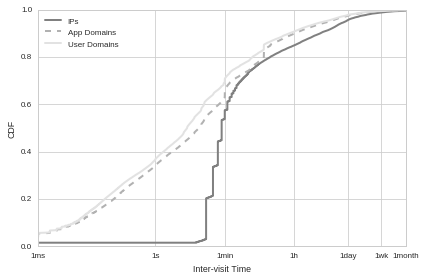

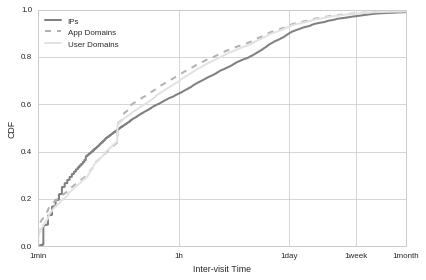

In [44]:
ses = Session()

#    correlation of visits to sites over multiple days
# => cdf of inter-visit times
iv = []
iv2 = []
iv3 = []

topx = 100

for rank,uid in enumerate(sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True)):
    q = ses.query(distinct(DeviceAppTraffic.dstip)).filter(DeviceAppTraffic.devid.in_(devsperuser[uid]))
    for row in q.all()[:topx]:
        ts = None
        iv.append(0) # first visit
        q2 = ses.query(DeviceAppTraffic.ts).filter(DeviceAppTraffic.dstip==row[0]).order_by(DeviceAppTraffic.ts)
        for row2 in q2.all():
            if (ts != None and (row2[0]-ts).total_seconds()>10): # 10s is the sample iv
                iv.append((row2[0]-ts).total_seconds())
            ts = row2[0]

    # unique app domains 
    q = ses.query(distinct(DnsReq.query)).filter(DnsReq.devid.in_(devsperuser[uid]))
    for row in q.all()[:topx]:
        ts = None
        iv2.append(0) # first visit
        q2 = ses.query(DnsReq.ts).filter(DnsReq.query==row[0]).order_by(DnsReq.ts)
        for row2 in q2.all():
            if (ts != None):
                iv2.append((row2[0]-ts).total_seconds())
            ts = row2[0]
            
    q = ses.query(distinct(HttpReq.req_url_host)).filter(HttpReq.devid.in_(devsperuser[uid]))
    for row in q.all()[:topx]:
        ts = None
        iv2.append(0) # first visit
        q2 = ses.query(HttpReq.ts).filter(HttpReq.req_url_host==row[0]).order_by(HttpReq.ts)
        for row2 in q2.all():
            if (ts != None):
                iv2.append((row2[0]-ts).total_seconds())
            ts = row2[0]

    # unique user domains
    q = ses.query(distinct(DnsReq.query)).filter(
            DnsReq.devid.in_(devsperuser[uid]),
            DnsReq.user_req==True, DnsReq.duplicate==False)
    for row in q.all()[:topx]:
        ts = None
        iv3.append(0) # first visit
        q2 = ses.query(DnsReq.ts).filter(DnsReq.query==row[0]).order_by(DnsReq.ts)
        for row2 in q2.all():
            if (ts != None):
                iv3.append((row2[0]-ts).total_seconds())
            ts = row2[0]
            
    q = ses.query(distinct(HttpReq.req_url_host)).filter(
            HttpReq.devid.in_(devsperuser[uid]),
            HttpReq.user_url==True)
    for row in q.all()[:topx]:
        ts = None
        iv3.append(0) # first visit
        q2 = ses.query(HttpReq.ts).filter(HttpReq.req_url_host==row[0]).order_by(HttpReq.ts)
        for row2 in q2.all():
            if (ts != None):
                iv3.append((row2[0]-ts).total_seconds())
            ts = row2[0]
            
            
f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf(iv)
ax1.plot(x,y, '-', lw=2, c=palette[0], label="IPs")

(x,y) = datautils.aecdf(iv2)
ax1.plot(x,y, '--', lw=2, c=palette[3], label="App Domains")

(x,y) = datautils.aecdf(iv3)
ax1.plot(x,y, '-', lw=2, c=palette[6], label="User Domains")


ax1.set_ylabel('CDF')
#ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Inter-visit Time')
ax1.set_xlim(0.1, 30*24*3600)
ax1.set_xticks([0.001,1, 60, 3600, 24*3600, 7*24*3600, 30*24*3600])
ax1.set_xticklabels(['1ms','1s','1min','1h','1day','1wk', '1month'])
ax1.legend(loc='best')

plt.tight_layout()
plt.show()
f.savefig("../figs/content_iv.eps")   


f, ax1 = plt.subplots(1, 1, figsize=(6,4))

(x,y) = datautils.aecdf([v for v in iv if v>60])
ax1.plot(x,y, '-', lw=2, c=palette[0], label="IPs")

(x,y) = datautils.aecdf([v for v in iv2 if v>60])
ax1.plot(x,y, '--', lw=2, c=palette[3], label="App Domains")

(x,y) = datautils.aecdf([v for v in iv3 if v>60])
ax1.plot(x,y, '-', lw=2, c=palette[6], label="User Domains")


ax1.set_ylabel('CDF')
#ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Inter-visit Time')
ax1.set_xlim(60, 30*24*3600)
ax1.set_xticks([60, 3600, 24*3600, 7*24*3600, 30*24*3600])
ax1.set_xticklabels(['1min','1h','1day','1week', '1month'])
ax1.legend(loc='best')

plt.tight_layout()
plt.show()
f.savefig("../figs/content_ivzoom.eps")   


ses.close()

In [ ]:
#    correlation of devices with categories of site visited
